# Construct the training data into Data format

In [56]:
import sys
sys.path.append("../src")

import torch
import pandas as pd
import numpy as np
from ast import literal_eval
from collections import Counter
from torch_geometric.data import Data
from reachability_model_function import build_graph_reachability
from dataset_function import generate_labeled_route_no_sides
from torch_geometric.loader import DataLoader
from reachability_model_function import ReachabilityGNN
from sklearn.model_selection import  train_test_split
from sklearn.metrics import classification_report
import torch.nn as nn
from sklearn.utils.class_weight import compute_class_weight

In [2]:
dataset = pd.read_csv("../data/reachability_dataset.csv")

In [3]:
for name in dataset.columns:
    dataset[name] = dataset[name].apply(literal_eval)

In [4]:
# graph_list: each graph is a training sample
graph_list = []

for _, row in dataset.iterrows():
    labels = generate_labeled_route_no_sides(row["route"], row["hands"], row["feet"], row["climber"])
    if labels.count(0) / len(labels) < 0.95:
        data = build_graph_reachability(row["route"], row["hands"], row["feet"], row["climber"], labels)
        graph_list.append(data)

In [6]:
len(graph_list)

89898

In [7]:
# Save the graph_list to local
torch.save(graph_list, "graph_list_global.pt")

# Train the Model

In [51]:
# Load pt file
graph_list = torch.load("graph_list_global.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_31220\1285557832.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list_global.pt")


In [52]:
train_data, test_data = train_test_split(graph_list, test_size=0.2, random_state=42)

In [9]:
all_labels = torch.cat([g.y for g in train_data])
counts = Counter(all_labels.tolist())
total = sum(counts.values())

max_cap = 5
weights = [min(np.log(total / (counts.get(i, 1) + 1)), max_cap) for i in range(4)]
weights = torch.tensor(weights, dtype=torch.float)

print("Used Weights:", weights)

Used Weights: tensor([0.3115, 1.8765, 5.0000, 2.1835])


# Use Balanced

In [57]:
all_train_labels = []
for g in train_data:
    all_train_labels.extend(g.y.cpu().numpy())  # 每个图的点标签

# 2. 使用 sklearn 自动计算 balanced class weights
classes = np.unique(all_train_labels)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=all_train_labels)
weights = torch.tensor(weights, dtype=torch.float)

print("Balanced weights:", weights)

Balanced weights: tensor([  0.3414,   1.6327, 134.3861,   2.2193])


In [58]:
# shuffle=True: Shuffle the order of the graph at each epoch to enhance the model's generalisation ability.
loader = DataLoader(train_data, batch_size=8, shuffle=True)
model = ReachabilityGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss(weight=weights)

for epoch in range(30):
    total_loss = 0
    model.train()
    for batch in loader:
        out = model(batch)
        loss = loss_fn(out, batch.y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 0, Loss: 7109.9716
Epoch 1, Loss: 5677.6304
Epoch 2, Loss: 5335.6174
Epoch 3, Loss: 5167.1275
Epoch 4, Loss: 5080.2648
Epoch 5, Loss: 4976.6633
Epoch 6, Loss: 5023.7781
Epoch 7, Loss: 4933.3204
Epoch 8, Loss: 4803.1786
Epoch 9, Loss: 4744.4210
Epoch 10, Loss: 4701.7200
Epoch 11, Loss: 4690.0119
Epoch 12, Loss: 4634.0292
Epoch 13, Loss: 4625.7792
Epoch 14, Loss: 4706.2714
Epoch 15, Loss: 4645.7544
Epoch 16, Loss: 4639.5538
Epoch 17, Loss: 4497.5615
Epoch 18, Loss: 4500.3877
Epoch 19, Loss: 4478.1881
Epoch 20, Loss: 4506.7445
Epoch 21, Loss: 4475.1784
Epoch 22, Loss: 4513.4590
Epoch 23, Loss: 4470.9852
Epoch 24, Loss: 4510.8386
Epoch 25, Loss: 4730.5666
Epoch 26, Loss: 4637.9357
Epoch 27, Loss: 4395.8009
Epoch 28, Loss: 4389.2415
Epoch 29, Loss: 4447.1506


In [63]:
from torch_geometric.data import Batch
from collections import Counter

model.eval()
all_preds = []

with torch.no_grad():
    for g in train_data:
        batch = Batch.from_data_list([g])     
        out = model(batch)                    
        pred = out.argmax(dim=1)
        all_preds.extend(pred.tolist())

print("Distribution of Predictions:", Counter(all_preds))

Distribution of Predictions: Counter({0: 4401639, 1: 1387005, 3: 910674, 2: 420996})


In [ ]:
model.eval()
with torch.no_grad():
    preds = []
    for g in graph_list[:30]:
        p = model(g).argmax(dim=1)
        preds.extend(p.tolist())

print("Distribution of Predictions:", Counter(preds))

In [60]:
torch.save(model.state_dict(),"reachability_model6.pt")

In [61]:
# Load the model
model = ReachabilityGNN()
model.load_state_dict(torch.load("reachability_model6.pt"))
model.eval()

C:\Users\guanj\AppData\Local\Temp\ipykernel_31220\3563426266.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("reachability_model6.pt"))


ReachabilityGNN(
  (conv1): GCNConv(6, 64)
  (conv2): GCNConv(64, 64)
  (climber_embed): Linear(in_features=4, out_features=64, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=4, bias=True)
  )
)

In [2]:
graph_list = torch.load("graph_list.pt")

C:\Users\guanj\AppData\Local\Temp\ipykernel_14260\2863085696.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_list = torch.load("graph_list.pt")


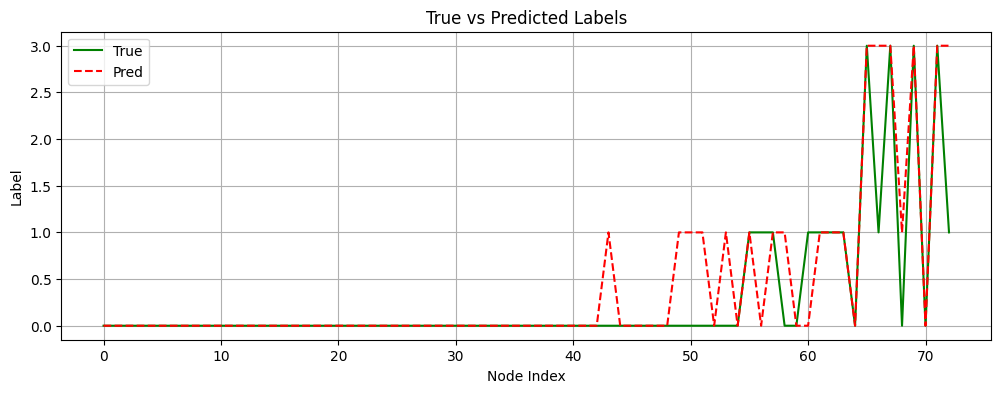

In [65]:
import matplotlib.pyplot as plt
graph = test_data[2450]
batch = Batch.from_data_list([graph])

with torch.no_grad():
    pred_logits = model(batch)
    pred_labels = pred_logits.argmax(dim=1)

# 转 numpy
true = graph.y.cpu().numpy()
pred = pred_labels.cpu().numpy()

# 绘图
plt.figure(figsize=(12, 4))
plt.plot(true, label='True', color='green')
plt.plot(pred, label='Pred', linestyle='--', color='red')
plt.legend()
plt.title("True vs Predicted Labels")
plt.xlabel("Node Index")
plt.ylabel("Label")
plt.grid(True)
plt.show()

In [62]:
all_preds, all_trues = [], []
model.eval()
with torch.no_grad():
    for g in test_data:
        batch = Batch.from_data_list([g])  
        out = model(batch)
        pred = out.argmax(dim=1).cpu().numpy()
        true = batch.y.cpu().numpy()
        all_preds.extend(pred)
        all_trues.extend(true)

print(classification_report(all_trues, all_preds, target_names=["unreachable", "hand", "foot", "both"]))

              precision    recall  f1-score   support

 unreachable       0.99      0.83      0.90   1297835
        hand       0.54      0.70      0.61    269960
        foot       0.03      0.95      0.06      3458
        both       0.69      0.77      0.73    201083

    accuracy                           0.80   1772336
   macro avg       0.56      0.81      0.58   1772336
weighted avg       0.88      0.80      0.84   1772336

